LANDMARK DETECTION

In [1]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
import tensorflow.compat.v2 as tf
samples = 20000
df = pd.read_csv("train.csv")
base_path ="./images/"
df = df.loc[:samples,:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)
data = pd.DataFrame(df['landmark_id'].value_counts())
#index the data frame
data.reset_index(inplace=True) 
data.columns=['landmark_id','count']
print(data.head(10))
print(data.tail(10))
print(data['count'].describe())#statistical data for the distribution
plt.hist(data['count'],100,range = (0,944),label = 'test')#Histogram of the distribution
plt.xlabel("Amount of images")
plt.ylabel("Occurences")
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0,5)).sum()) 
print("Amount of classes between five and 10 datapoints:", (data['count'].between(5,10)).sum())
unique_landmark_ids = df["landmark_id"].unique()
unique_landmark_ids.sort()  # Sort the unique values in increasing order
n = plt.hist(df["landmark_id"], bins=unique_landmark_ids)
freq_info = n[0]
plt.xlim(0,data['landmark_id'].max())
plt.ylim(0,data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')

from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])
def encode_label(lbl):
    return lencoder.transform(lbl)
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
def get_image_from_number(num):
    fname, label = df.loc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path+'/'+a[0]+'/'+a[1]+'/'+a[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
# Parameters
# learning_rate   = 0.0001
# decay_speed     = 1e-6
# momentum        = 0.09
# loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled! n")
#Function used to process the data, fitted into a data generator.
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)
def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    end_img = start+batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)
    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 15
# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        model.train_on_batch(X_train, y_train)
model.save("Model.h5")
### Test on the training set
batch_size = 16
errors = 0
good_preds = []
bad_preds = []
for it in range(int(np.ceil(len(validate)/batch_size))):
    X_train, y_train = get_batch(validate, it*batch_size, batch_size)
    result = model.predict(X_train)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        print("Class:", cla[idx], "- Confidence:", np.round(res[cla[idx]],2), "- GT:", y_train[idx])
        if cla[idx] != y_train[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
print("Errors: ", errors, "Acc:", np.round(100*(len(validate)-errors)/len(validate),2))
#Good predictions
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))
fig=plt.figure(figsize=(16, 16))
for i in range(1,6):
    n = int(good_preds[i,0])
    img, lbl = get_image_from_number(n, validate)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "nClassified as: " + str(decode_label(lbl2)) + "nSamples in class " + str(lbl) + ": " + str(sample_cnt))
    plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'numpy'

In [2]:
pip install numpy


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: c:\Users\soni\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip



                                              0.0/15.8 MB ? eta -:--:--
                                              0.2/15.8 MB 6.9 MB/s eta 0:00:03
     -                                        0.5/15.8 MB 5.0 MB/s eta 0:00:04
     -                                        0.7/15.8 MB 5.5 MB/s eta 0:00:03
     --                                       1.0/15.8 MB 5.0 MB/s eta 0:00:03
     ---                                      1.2/15.8 MB 5.0 MB/s eta 0:00:03
     ---                                      1.4/15.8 MB 5.1 MB/s eta 0:00:03
     ----                                     1.8/15.8 MB 5.3 MB/s eta 0:00:03
     -----                                    2.1/15.8 MB 5.3 MB/s eta 0:00:03
     -----                                    2.3/15.8 MB 5.2 MB/s eta 0:00:03
     ------                                   2.5/15.8 MB 5.2 MB/s eta 0:00:03
     -------                                  2.8/15.8 MB 5.3 MB/s eta 0:00:03
     -------                                  2.8/15.8 MB 

In [3]:
pip install pandas

                                              0.0/10.6 MB ? eta -:--:--
                                              0.3/10.6 MB 7.7 MB/s eta 0:00:02
     --                                       0.6/10.6 MB 7.2 MB/s eta 0:00:02
     --                                       0.8/10.6 MB 6.1 MB/s eta 0:00:02
     ---                                      1.0/10.6 MB 6.0 MB/s eta 0:00:02
     ----                                     1.3/10.6 MB 5.8 MB/s eta 0:00:02
     ------                                   1.6/10.6 MB 6.0 MB/s eta 0:00:02
     ------                                   1.8/10.6 MB 5.8 MB/s eta 0:00:02
     -------                                  2.1/10.6 MB 5.8 MB/s eta 0:00:02
     --------                                 2.3/10.6 MB 5.7 MB/s eta 0:00:02
     ---------                                2.6/10.6 MB 5.7 MB/s eta 0:00:02
     ----------                               2.8/10.6 MB 5.6 MB/s eta 0:00:02
     -----------                              3.1/10.6 MB 5


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: c:\Users\soni\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [4]:
pip install keras


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: c:\Users\soni\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip



                                              0.0/999.1 kB ? eta -:--:--
     -----                                  153.6/999.1 kB 3.1 MB/s eta 0:00:01
     -------------                          358.4/999.1 kB 3.7 MB/s eta 0:00:01
     ---------------                        409.6/999.1 kB 2.9 MB/s eta 0:00:01
     ---------------------                  573.4/999.1 kB 3.0 MB/s eta 0:00:01
     -------------------------------        819.2/999.1 kB 3.5 MB/s eta 0:00:01
     -------------------------------------  993.3/999.1 kB 3.5 MB/s eta 0:00:01
     -------------------------------------  993.3/999.1 kB 3.5 MB/s eta 0:00:01
     -------------------------------------- 999.1/999.1 kB 2.8 MB/s eta 0:00:00
                                              0.0/130.2 kB ? eta -:--:--
     -----------------------------------    122.9/130.2 kB 7.0 MB/s eta 0:00:01
     -------------------------------------- 130.2/130.2 kB 1.9 MB/s eta 0:00:00
                                              0.0/240

In [5]:
pip install matplotlib

                                              0.0/7.6 MB ? eta -:--:--
                                              0.2/7.6 MB 4.8 MB/s eta 0:00:02
     --                                       0.4/7.6 MB 5.0 MB/s eta 0:00:02
     --                                       0.4/7.6 MB 3.4 MB/s eta 0:00:03
     ---                                      0.6/7.6 MB 3.6 MB/s eta 0:00:02
     ----                                     0.8/7.6 MB 3.7 MB/s eta 0:00:02
     -----                                    1.0/7.6 MB 3.8 MB/s eta 0:00:02
     ------                                   1.2/7.6 MB 4.0 MB/s eta 0:00:02
     -------                                  1.4/7.6 MB 3.8 MB/s eta 0:00:02
     --------                                 1.6/7.6 MB 4.0 MB/s eta 0:00:02
     ---------                                1.9/7.6 MB 4.1 MB/s eta 0:00:02
     ----------                               2.1/7.6 MB 4.2 MB/s eta 0:00:02
     -----------                              2.2/7.6 MB 4.0 MB/s eta 0


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: c:\Users\soni\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [6]:
pip install tensorflow


                                              0.0/300.9 MB ? eta -:--:--
                                              0.2/300.9 MB 4.6 MB/s eta 0:01:06
                                              0.4/300.9 MB 5.0 MB/s eta 0:01:01
                                              0.5/300.9 MB 4.9 MB/s eta 0:01:02
                                              0.7/300.9 MB 4.3 MB/s eta 0:01:11
                                              0.9/300.9 MB 4.1 MB/s eta 0:01:14
                                              1.1/300.9 MB 4.1 MB/s eta 0:01:13
                                              1.3/300.9 MB 4.2 MB/s eta 0:01:11
                                              1.5/300.9 MB 4.1 MB/s eta 0:01:14
                                              1.7/300.9 MB 4.3 MB/s eta 0:01:11
                                              1.8/300.9 MB 4.2 MB/s eta 0:01:12
                                              2.0/300.9 MB 3.9 MB/s eta 0:01:17
                                              


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: c:\Users\soni\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip



                                              0.0/1.5 MB ? eta -:--:--
     ----                                     0.2/1.5 MB 3.8 MB/s eta 0:00:01
     ----------                               0.4/1.5 MB 4.9 MB/s eta 0:00:01
     ---------------                          0.6/1.5 MB 3.9 MB/s eta 0:00:01
     ----------------------                   0.8/1.5 MB 4.3 MB/s eta 0:00:01
     ---------------------------              1.0/1.5 MB 4.2 MB/s eta 0:00:01
     --------------------------------         1.2/1.5 MB 4.3 MB/s eta 0:00:01
     --------------------------------------   1.4/1.5 MB 4.3 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 4.3 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 4.3 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 3.4 MB/s eta 0:00:00
                                              0.0/3.7 MB ? eta -:--:--
     -----                                    0.5/3.7 MB 10.2 MB/s eta 0:00:0

In [8]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
import tensorflow.compat.v2 as tf
samples = 20000
df = pd.read_csv("train.csv")
base_path ="./images/"
df = df.loc[:samples,:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)
data = pd.DataFrame(df['landmark_id'].value_counts())
#index the data frame
data.reset_index(inplace=True) 
data.columns=['landmark_id','count']
print(data.head(10))
print(data.tail(10))
print(data['count'].describe())#statistical data for the distribution
plt.hist(data['count'],100,range = (0,944),label = 'test')#Histogram of the distribution
plt.xlabel("Amount of images")
plt.ylabel("Occurences")
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0,5)).sum()) 
print("Amount of classes between five and 10 datapoints:", (data['count'].between(5,10)).sum())
unique_landmark_ids = df["landmark_id"].unique()
unique_landmark_ids.sort()  # Sort the unique values in increasing order
n = plt.hist(df["landmark_id"], bins=unique_landmark_ids)
freq_info = n[0]
plt.xlim(0,data['landmark_id'].max())
plt.ylim(0,data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')

from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])
def encode_label(lbl):
    return lencoder.transform(lbl)
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
def get_image_from_number(num):
    fname, label = df.loc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path+'/'+a[0]+'/'+a[1]+'/'+a[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
# Parameters
# learning_rate   = 0.0001
# decay_speed     = 1e-6
# momentum        = 0.09
# loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled! n")
#Function used to process the data, fitted into a data generator.
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)
def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    end_img = start+batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)
    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 15
# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        model.train_on_batch(X_train, y_train)
model.save("Model.h5")
### Test on the training set
batch_size = 16
errors = 0
good_preds = []
bad_preds = []
for it in range(int(np.ceil(len(validate)/batch_size))):
    X_train, y_train = get_batch(validate, it*batch_size, batch_size)
    result = model.predict(X_train)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        print("Class:", cla[idx], "- Confidence:", np.round(res[cla[idx]],2), "- GT:", y_train[idx])
        if cla[idx] != y_train[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
print("Errors: ", errors, "Acc:", np.round(100*(len(validate)-errors)/len(validate),2))
#Good predictions
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))
fig=plt.figure(figsize=(16, 16))
for i in range(1,6):
    n = int(good_preds[i,0])
    img, lbl = get_image_from_number(n, validate)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "nClassified as: " + str(decode_label(lbl2)) + "nSamples in class " + str(lbl) + ": " + str(sample_cnt))
    plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'cv2'

In [9]:
pip install opencv-python


                                              0.0/38.1 MB ? eta -:--:--
                                              0.2/38.1 MB 6.3 MB/s eta 0:00:07
                                              0.5/38.1 MB 5.6 MB/s eta 0:00:07
                                              0.7/38.1 MB 5.4 MB/s eta 0:00:07
                                              0.9/38.1 MB 5.2 MB/s eta 0:00:08
     -                                        1.1/38.1 MB 5.1 MB/s eta 0:00:08
     -                                        1.4/38.1 MB 5.1 MB/s eta 0:00:08
     -                                        1.5/38.1 MB 4.9 MB/s eta 0:00:08
     -                                        1.6/38.1 MB 4.7 MB/s eta 0:00:08
     -                                        1.6/38.1 MB 4.7 MB/s eta 0:00:08
     -                                        1.6/38.1 MB 4.7 MB/s eta 0:00:08
     -                                        1.6/38.1 MB 3.2 MB/s eta 0:00:12
     -                                        1.8/38.1 MB 


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: c:\Users\soni\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


Size of training data: (20001, 3)
Number of unique classes: 16342
   landmark_id  count
0       138982     57
1       177870     22
2        62798     20
3       192931     16
4        83144     14
5       171772     14
6       176528     14
7        45428     11
8        84689     10
9       164773     10
       landmark_id  count
16332       147159      1
16333        20310      1
16334        80664      1
16335       149246      1
16336       162189      1
16337        61959      1
16338       194142      1
16339       171822      1
16340        55962      1
16341         4406      1
count    16342.000000
mean         1.223902
std          0.825061
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         57.000000
Name: count, dtype: float64
Amount of classes with less than or equal to five datapoints: 16281
Amount of classes between five and 10 datapoints: 92


KeyboardInterrupt: 

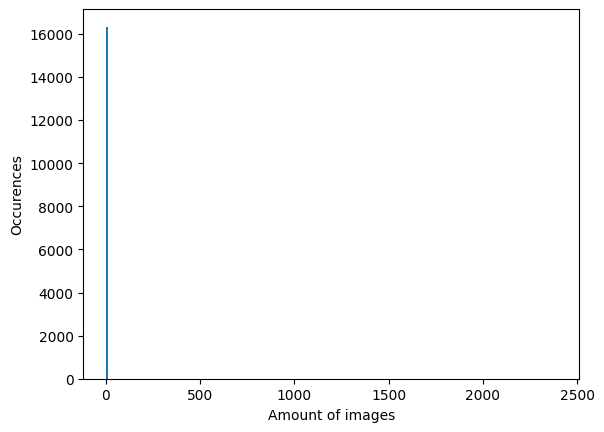

In [11]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
import tensorflow.compat.v2 as tf
samples = 20000
df = pd.read_csv("train.csv")
base_path ="./images/"
df = df.loc[:samples,:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)
data = pd.DataFrame(df['landmark_id'].value_counts())
#index the data frame
data.reset_index(inplace=True) 
data.columns=['landmark_id','count']
print(data.head(10))
print(data.tail(10))
print(data['count'].describe())#statistical data for the distribution
plt.hist(data['count'],100,range = (0,944),label = 'test')#Histogram of the distribution
plt.xlabel("Amount of images")
plt.ylabel("Occurences")
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0,5)).sum()) 
print("Amount of classes between five and 10 datapoints:", (data['count'].between(5,10)).sum())
unique_landmark_ids = df["landmark_id"].unique()
unique_landmark_ids.sort()  # Sort the unique values in increasing order
n = plt.hist(df["landmark_id"], bins=unique_landmark_ids)
freq_info = n[0]
plt.xlim(0,data['landmark_id'].max())
plt.ylim(0,data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')

from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])
def encode_label(lbl):
    return lencoder.transform(lbl)
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
def get_image_from_number(num):
    fname, label = df.loc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path+'/'+a[0]+'/'+a[1]+'/'+a[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
# Parameters
# learning_rate   = 0.0001
# decay_speed     = 1e-6
# momentum        = 0.09
# loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled! n")
#Function used to process the data, fitted into a data generator.
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)
def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    end_img = start+batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)
    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 15
# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        model.train_on_batch(X_train, y_train)
model.save("Model.h5")
### Test on the training set
batch_size = 16
errors = 0
good_preds = []
bad_preds = []
for it in range(int(np.ceil(len(validate)/batch_size))):
    X_train, y_train = get_batch(validate, it*batch_size, batch_size)
    result = model.predict(X_train)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        print("Class:", cla[idx], "- Confidence:", np.round(res[cla[idx]],2), "- GT:", y_train[idx])
        if cla[idx] != y_train[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
print("Errors: ", errors, "Acc:", np.round(100*(len(validate)-errors)/len(validate),2))
#Good predictions
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))
fig=plt.figure(figsize=(16, 16))
for i in range(1,6):
    n = int(good_preds[i,0])
    img, lbl = get_image_from_number(n, validate)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "nClassified as: " + str(decode_label(lbl2)) + "nSamples in class " + str(lbl) + ": " + str(sample_cnt))
    plt.axis('off')
plt.show()

In [1]:
pip install scikit-learn

                                              0.0/9.2 MB ? eta -:--:--
     -                                        0.3/9.2 MB 6.8 MB/s eta 0:00:02
     --                                       0.7/9.2 MB 6.0 MB/s eta 0:00:02
     ----                                     0.9/9.2 MB 6.5 MB/s eta 0:00:02
     ----                                     1.1/9.2 MB 6.0 MB/s eta 0:00:02
     ------                                   1.4/9.2 MB 5.5 MB/s eta 0:00:02
     -------                                  1.6/9.2 MB 5.7 MB/s eta 0:00:02
     -------                                  1.8/9.2 MB 5.6 MB/s eta 0:00:02
     --------                                 2.0/9.2 MB 5.3 MB/s eta 0:00:02
     ---------                                2.2/9.2 MB 5.3 MB/s eta 0:00:02
     -----------                              2.6/9.2 MB 5.5 MB/s eta 0:00:02
     -----------                              2.7/9.2 MB 5.3 MB/s eta 0:00:02
     -------------                            3.1/9.2 MB 5.4 MB/s eta 0


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: c:\Users\soni\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
import tensorflow.compat.v2 as tf
samples = 20000
df = pd.read_csv("train.csv")
base_path ="C:\Python311"
df = df.loc[:samples,:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)
data = pd.DataFrame(df['landmark_id'].value_counts())
#index the data frame
data.reset_index(inplace=True) 
data.columns=['landmark_id','count']
print(data.head(10))
print(data.tail(10))
print(data['count'].describe())#statistical data for the distribution
plt.hist(data['count'],100,range = (0,944),label = 'test')#Histogram of the distribution
plt.xlabel("Amount of images")
plt.ylabel("Occurences")
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0,5)).sum()) 
print("Amount of classes between five and 10 datapoints:", (data['count'].between(5,10)).sum())
unique_landmark_ids = df["landmark_id"].unique()
unique_landmark_ids.sort()  # Sort the unique values in increasing order
n = plt.hist(df["landmark_id"], bins=unique_landmark_ids)
freq_info = n[0]
plt.xlim(0,data['landmark_id'].max())
plt.ylim(0,data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')

from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])
def encode_label(lbl):
    return lencoder.transform(lbl)
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
def get_image_from_number(num):
    fname, label = df.loc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path+'/'+a[0]+'/'+a[1]+'/'+a[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
# Parameters
# learning_rate   = 0.0001
# decay_speed     = 1e-6
# momentum        = 0.09
# loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
sgd = SGD(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled! n")
#Function used to process the data, fitted into a data generator.
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)
def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    end_img = start+batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)
    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 15
# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        model.train_on_batch(X_train, y_train)
model.save("Model.h5")
### Test on the training set
batch_size = 16
errors = 0
good_preds = []
bad_preds = []
for it in range(int(np.ceil(len(validate)/batch_size))):
    X_train, y_train = get_batch(validate, it*batch_size, batch_size)
    result = model.predict(X_train)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        print("Class:", cla[idx], "- Confidence:", np.round(res[cla[idx]],2), "- GT:", y_train[idx])
        if cla[idx] != y_train[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
print("Errors: ", errors, "Acc:", np.round(100*(len(validate)-errors)/len(validate),2))
#Good predictions
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))
fig=plt.figure(figsize=(16, 16))
for i in range(1,6):
    n = int(good_preds[i,0])
    img, lbl = get_image_from_number(n, validate)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "nClassified as: " + str(decode_label(lbl2)) + "nSamples in class " + str(lbl) + ": " + str(sample_cnt))
    plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [1]:
os.getcwd()

NameError: name 'os' is not defined

In [2]:
import os
os.getcwd()

'c:\\Python311'

The file exists.
Size of training data: (20001, 3)
Number of unique classes: 16342
   landmark_id  count
0       138982     57
1       177870     22
2        62798     20
3       192931     16
4        83144     14
5       171772     14
6       176528     14
7        45428     11
8        84689     10
9       164773     10
       landmark_id  count
16332       147159      1
16333        20310      1
16334        80664      1
16335       149246      1
16336       162189      1
16337        61959      1
16338       194142      1
16339       171822      1
16340        55962      1
16341         4406      1
count    16342.000000
mean         1.223902
std          0.825061
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         57.000000
Name: count, dtype: float64
Amount of classes with less than or equal to five datapoints: 16281
Amount of classes between five and 10 datapoints: 92
4 sample images from random classes:


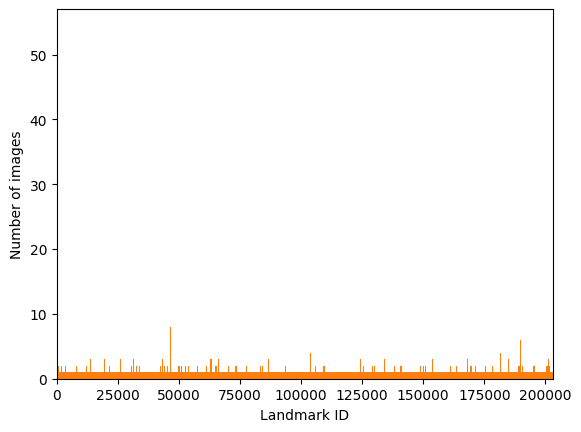

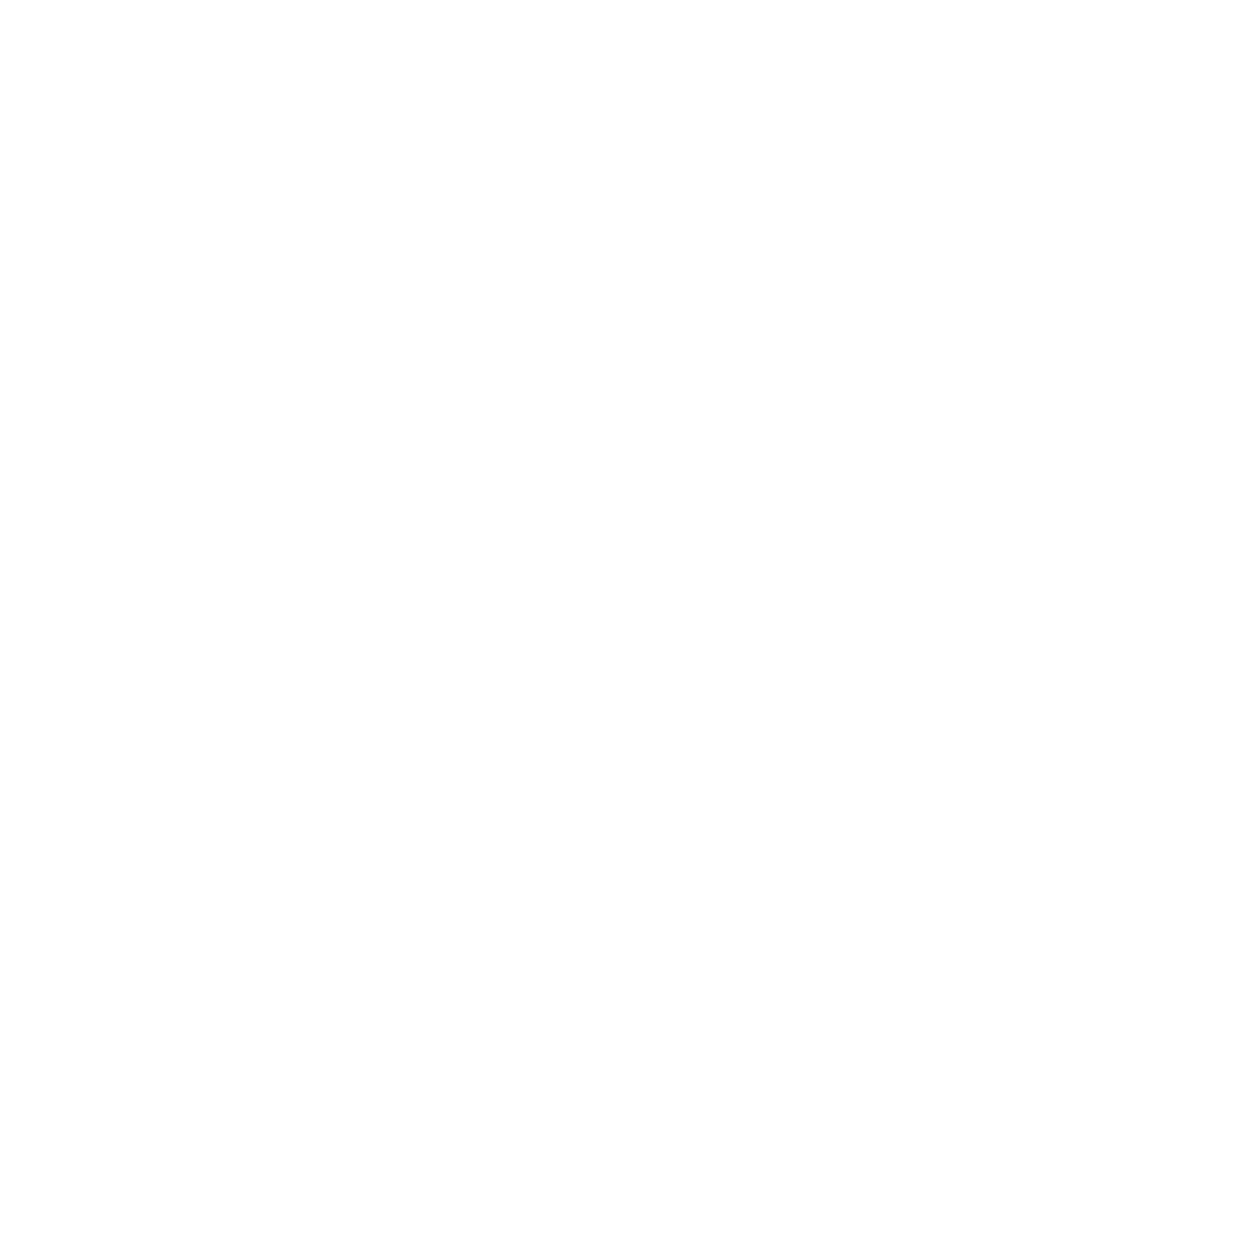

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Bat  (None, 224, 224, 3)       12        
 chNormalization)                                                
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                      

Model compiled! n


c:\Users\soni\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on: 16000 samples
Validation on: 4001 samples
Epoch:  1/15


ValueError: too many values to unpack (expected 2)

In [10]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
import tensorflow.compat.v2 as tf

samples = 20000
df = pd.read_csv("train.csv")

# Use raw string for the base path to avoid escape characters
base_path = r'C:/Python311'

if os.path.exists(base_path):
    print("The file exists.")
else:
    print("The file does not exist.")

df = df.loc[:samples, :]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)

# Rest of your code...

data = pd.DataFrame(df['landmark_id'].value_counts())
#index the data frame
data.reset_index(inplace=True) 
data.columns=['landmark_id','count']
print(data.head(10))
print(data.tail(10))
print(data['count'].describe())#statistical data for the distribution
plt.hist(data['count'],100,range = (0,944),label = 'test')#Histogram of the distribution
plt.xlabel("Amount of images")
plt.ylabel("Occurences")
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0,5)).sum()) 
print("Amount of classes between five and 10 datapoints:", (data['count'].between(5,10)).sum())
unique_landmark_ids = df["landmark_id"].unique()
unique_landmark_ids.sort()  # Sort the unique values in increasing order
n = plt.hist(df["landmark_id"], bins=unique_landmark_ids)
freq_info = n[0]
plt.xlim(0,data['landmark_id'].max())
plt.ylim(0,data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')

from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])
def encode_label(lbl):
    return lencoder.transform(lbl)
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
def get_image_from_number(num):
    fname, label = df.loc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
print("4 sample images from random classes:")
fig=plt.figure(figsize=(16, 16))
for i in range(1,5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path+'/'+a[0]+'/'+a[1]+'/'+a[2]
    #random_img = random.choice(os.listdir(folder))
    #img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1, 4, i)
    #plt.imshow(img)
    plt.axis('off')
plt.show()
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
# Parameters
learning_rate   = 0.0001
decay_speed     = 1e-6
momentum        = 0.09
loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
#     if layer == source_model.layers[-3]:
#         model.add(drop_layer)
# model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
#sgd = sgd(lr=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(lr=learning_rate, momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled! n")
#Function used to process the data, fitted into a data generator.
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)
def get_batch(dataframe,start, batch_size):
    image_array = []
    label_array = []
    end_img = start+batch_size
    if end_img > len(dataframe):
        end_img = len(dataframe)
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)
    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 15
# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        model.train_on_batch(X_train, y_train)
model.save("Model.h5")
### Test on the training set
batch_size = 16
errors = 0
good_preds = []
bad_preds = []
for it in range(int(np.ceil(len(validate)/batch_size))):
    X_train, y_train = get_batch(validate, it*batch_size, batch_size)
    result = model.predict(X_train)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        print("Class:", cla[idx], "- Confidence:", np.round(res[cla[idx]],2), "- GT:", y_train[idx])
        if cla[idx] != y_train[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
print("Errors: ", errors, "Acc:", np.round(100*(len(validate)-errors)/len(validate),2))
#Good predictions
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))
fig=plt.figure(figsize=(16, 16))
for i in range(1,6):
    n = int(good_preds[i,0])
    img, lbl = get_image_from_number(n, validate)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "nClassified as: " + str(decode_label(lbl2)) + "nSamples in class " + str(lbl) + ": " + str(sample_cnt))
    plt.axis('off')
plt.show()

In [3]:
import os
os.getcwd()

'c:\\Python311'

In [4]:
import os

# To change the current working directory to a specific folder
os.chdir('c:\\Python311')


In [2]:
os.getcwd()

'c:\\Python311'

The file exists.
Size of training data: (20001, 3)
Number of unique classes: 16342
   landmark_id  count
0       138982     57
1       177870     22
2        62798     20
3       192931     16
4        83144     14
5       171772     14
6       176528     14
7        45428     11
8        84689     10
9       164773     10
       landmark_id  count
16332       147159      1
16333        20310      1
16334        80664      1
16335       149246      1
16336       162189      1
16337        61959      1
16338       194142      1
16339       171822      1
16340        55962      1
16341         4406      1
count    16342.000000
mean         1.223902
std          0.825061
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         57.000000
Name: count, dtype: float64


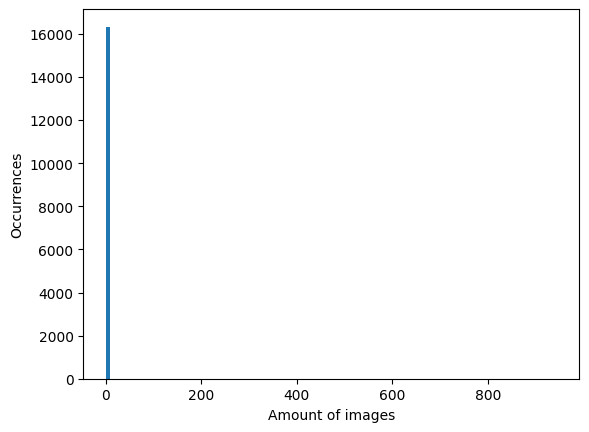

Amount of classes with less than or equal to five datapoints: 16281
Amount of classes between five and 10 datapoints: 92


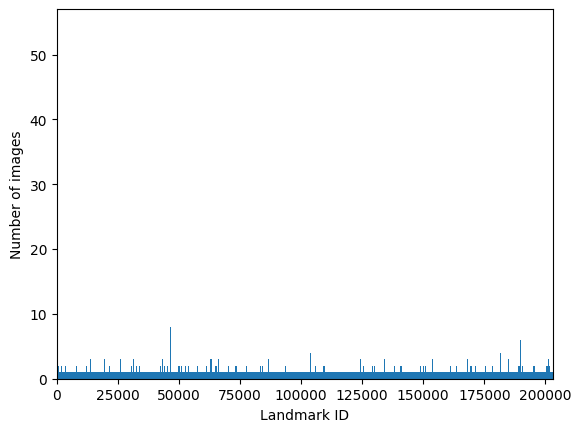

4 sample images from random classes:


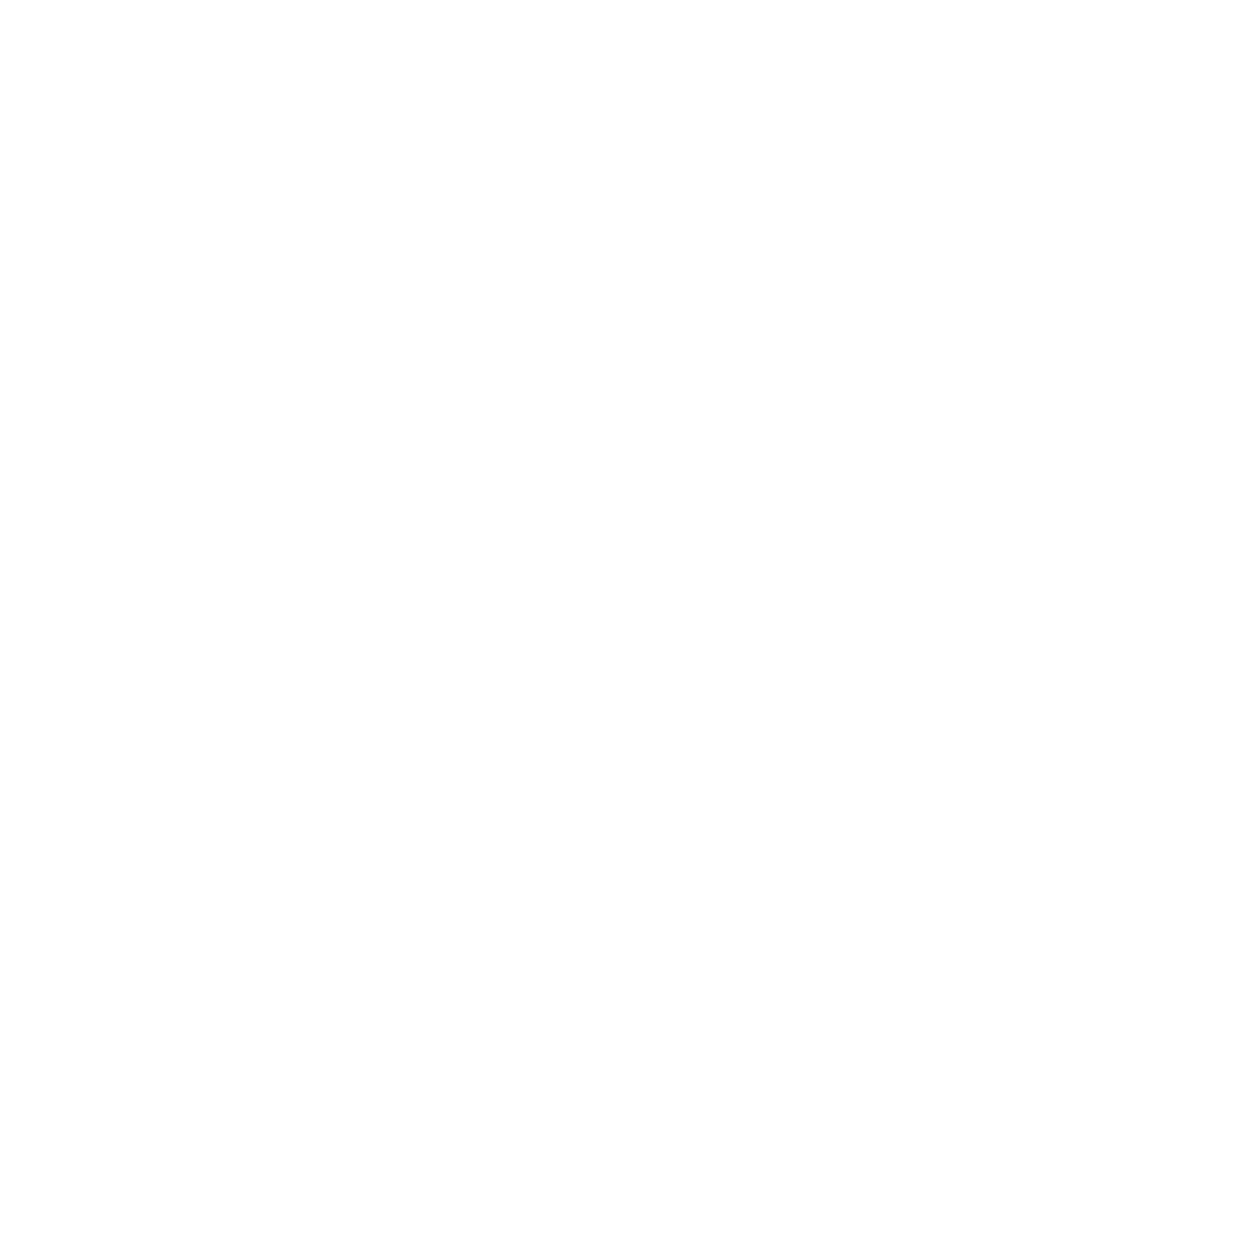

Training on: 16000 samples
Validation on: 4001 samples
Epoch: 1/15


NameError: name 'get_batch' is not defined

In [8]:
import numpy as np
import pandas as pd
from keras.applications import VGG19
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import random
from keras.optimizers import SGD

# Set the number of samples
samples = 20000

# Read the CSV file into a DataFrame
df = pd.read_csv("train.csv")

# Define the base path for image files
base_path = r'C:/Python311'

# Check if the base path exists
if os.path.exists(base_path):
    print("The file exists.")
else:
    print("The file does not exist.")

# Limit the DataFrame to the specified number of samples
df = df.loc[:samples, :]

# Get the number of unique classes and the total number of data points
num_classes = len(df["landmark_id"].unique())
num_data = len(df)
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)

# Display some information about the distribution of classes
data = pd.DataFrame(df['landmark_id'].value_counts())
data.reset_index(inplace=True)
data.columns = ['landmark_id', 'count']
print(data.head(10))
print(data.tail(10))
print(data['count'].describe())

# Plot a histogram of the distribution
plt.hist(data['count'], 100, range=(0, 944), label='test')
plt.xlabel("Amount of images")
plt.ylabel("Occurrences")
plt.show()

# Display additional information about the distribution
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0, 5)).sum())
print("Amount of classes between five and 10 datapoints:", (data['count'].between(5, 10)).sum())

# Extract unique landmark IDs and sort them
unique_landmark_ids = df["landmark_id"].unique()
unique_landmark_ids.sort()

# Display a histogram of landmark IDs
n = plt.hist(df["landmark_id"], bins=unique_landmark_ids)
freq_info = n[0]
plt.xlim(0, data['landmark_id'].max())
plt.ylim(0, data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')
plt.show()

# Use LabelEncoder to encode and decode landmark IDs
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

def encode_label(lbl):
    return lencoder.transform(lbl)

def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

# Function to get an image from its number
def get_image_from_number(num):
    fname, label = df.iloc[num, :]
    fname = fname + ".jpg"
    f1, f2, f3 = fname[0], fname[1], fname[2]
    path = os.path.join(f1, f2, f3, fname)
    im = cv2.imread(os.path.join(base_path, path))
    return im, label

# Display 4 sample images from random classes
print("4 sample images from random classes:")
fig = plt.figure(figsize=(16, 16))
for i in range(1, 5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = os.path.join(base_path, a[0], a[1], a[2])
   # random_img = random.choice(os.listdir(folder))
    #img = np.array(Image.open(os.path.join(folder, random_img)))
    fig.add_subplot(1, 4, i)
    #plt.imshow(img)
    plt.axis('off')
plt.show()

# Build the model using VGG19 as the base
source_model = VGG19(weights=None)
model = Sequential()

# Add layers from VGG19, add BatchNormalization before specific layers
for layer in source_model.layers[:-1]:
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)

# Add the output layer with the number of classes and softmax activation
model.add(Dense(num_classes, activation="softmax"))

# Compile the model using RMSprop optimizer
model.compile(optimizer=RMSprop(learning_rate=0.0001, momentum=0.09),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Set the parameters for training
epochs = 15
batch_size = 16

# Split the data into training and validation sets
train, validate = train_test_split(df, test_size=0.2, random_state=42)

print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")

# Train the model
for e in range(epochs):
    print("Epoch:", str(e + 1) + "/" + str(epochs))
    
    train = train.sample(frac=1)  # Shuffle the training data
    
    for it in range(int(np.ceil(len(train) / batch_size))):
        X_train, y_train = get_batch(train, it * batch_size, batch_size)
        model.train_on_batch(X_train, y_train)

# Save the trained model
model.save("Model.h5")

# Continue with testing and visualization if needed...


Size of training data: (16157, 3)
Number of unique classes: 13589


ValueError: `bins` must increase monotonically, when an array

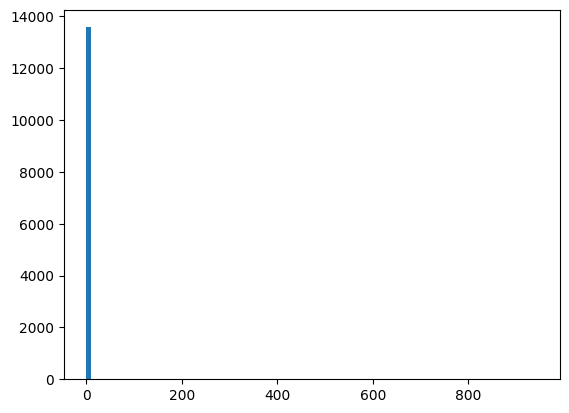

In [3]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image

df= pd.read_csv("train.csv")

samples = 20000

base_path ="C:\Python311"
df = df.loc[df["id"].str.startswith('00',na=False),:]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)
data = pd.DataFrame(df['landmark_id'].value_counts())
data.reset_index(inplace=True)
data.head()
data.tail()
data.columns=['landmark_id','count']
data['count'].describe()
plt.hist(data['count'],100,range = (0,944), label = 'test')
data['count'].between(0,5).sum()
data['count'].between(5,10).sum()
plt.hist(df["landmark_id"],bins=df["landmark_id"].unique())

# Training of Model

from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fir(df["landmark_id"])
df.head()
def encode_label(lbl):
    return lencoder.transform(lbl)
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)
def get_image_from_number(num):
    fname,label =df.loc[num,:]
    fname = fname + '.jpg'
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path),path)
    return im, label
print("4 Sample images from random classes")
fig = plt.figure(figsize=(16,16))
for i in range(1,5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = base_path  + '/' + ri[0] + '/' + ri[1] + '/' + ri[2]
    random_img =  random.choice(os.listdir(folder))
    img = np.array(Image.opne(folder+'/'+random_img))
    fig.add_subplot(1,4,i)
    plt.imshow(img)
    plt.axis("off")
plt.show()

from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential
tf.compat.v1.disable_eager_execution()
# Parameters
learning_rate   = 0.0001
decay_speed     = 1e-6
momentum        = 0.09
loss_function   = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)
model = Sequential()
for layer in source_model.layers[:-1]:
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
model.add(Dense(num_classes,activation = "softmax"))
model.summary()

optim1 = keras.optimizer_v1.RMSprop(lr=learning_rate)
model.compile(optimizer = optim1,
              loss=loss_function,
              metrics=["accuracy"])

def image_reshape(im,target_size):
    return cv2.reshape(im, target_size)
def get_batch(dataFrame , start , batch_size):
    image_array = []
    label_array = []

    end_img = start+batch_size
    if(end_img) > len(dataFrame):
        end_img = len(dataFrame)
    
    for idx in range(start,end_img):
        n=idx
        im, label =get_image_from_number(n,dataFrame)
        im = image_reshape(im,(224,224))/255.0
        image_array.append(im)
        label_array.append(label)
    
    label_array = encode_label(label_array)
    return np.array(image_array) , np.array(label_array)

batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 1

#split
train,val=np.split(df.sample(frac=1),[int(0.8*len(df))])
print(len(train))
print(len(val))
for e in epochs:
    print("Epoch :" + str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        x_train, y_train = get_batch(train,it*batch_size,batch_size)

        model.train_on_batch(x_train, y_train)
    model.save("Model")

    #Test

    batch_size=16
    errors = 0
    good_preds=[]
    bad_pred = []

    for it in range(int(np.ceil(len(val)/batch_size))):
        x_val , y_val = get_batch(val,it*batch_size,batch_size)
        result = model.predict(x_val)
        cla = np.argmax(result,axis = 1)
        for idx, res in enumerate(result):
            if cla[idx] != y_val[idx]:
                errors = errors + 1
                bad_pred.append([batch_size*it +idx],cla[idx],res[cla[idx]])
            else:
                good_preds.append([batch_size*it+idx],cla[idx],res[cla[idx]])
    
    for i in range(1,6):
        n = int(good_preds[0])
        img, lbl = get_image_from_number(n,val)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)


The file exists.
Size of training data: (20001, 3)
Number of unique classes: 16342
   landmark_id  count
0       138982     57
1       177870     22
2        62798     20
3       192931     16
4        83144     14
5       171772     14
6       176528     14
7        45428     11
8        84689     10
9       164773     10
       landmark_id  count
16332       147159      1
16333        20310      1
16334        80664      1
16335       149246      1
16336       162189      1
16337        61959      1
16338       194142      1
16339       171822      1
16340        55962      1
16341         4406      1
count    16342.000000
mean         1.223902
std          0.825061
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         57.000000
Name: count, dtype: float64


IndexError: list index out of range

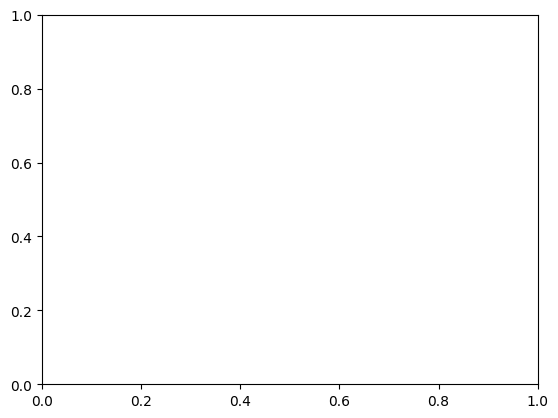

In [5]:
import numpy as np
import pandas as pd
from keras.applications import VGG19
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import random
from keras.optimizers import SGD

# Set the number of samples
samples = 20000

# Read the CSV file into a DataFrame
df = pd.read_csv("train.csv")

# Define the base path for image files
base_path = r'C:/Python311'

# Check if the base path exists
if os.path.exists(base_path):
    print("The file exists.")
else:
    print("The file does not exist.")

# Limit the DataFrame to the specified number of samples
df = df.loc[:samples, :]

# Get the number of unique classes and the total number of data points
num_classes = len(df["landmark_id"].unique())
num_data = len(df)
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)

# Display some information about the distribution of classes
data = pd.DataFrame(df['landmark_id'].value_counts())
data.reset_index(inplace=True)
data.columns = ['landmark_id', 'count']
print(data.head(10))
print(data.tail(10))
print(data['count'].describe())

# Plot a histogram of the distribution
plt.hist(data['count'], 100, range=(0, 944), label='test')
plt.xlabel("Amount of images")
plt.ylabel("Occurrences")
plt.show()

# Display additional information about the distribution
print("Amount of classes with less than or equal to five datapoints:", (data['count'].between(0, 5)).sum())
print("Amount of classes between five and 10 datapoints:", (data['count'].between(5, 10)).sum())

# Extract unique landmark IDs and sort them
unique_landmark_ids = df["landmark_id"].unique()
unique_landmark_ids.sort()

# Display a histogram of landmark IDs
n = plt.hist(df["landmark_id"], bins=unique_landmark_ids)
freq_info = n[0]
plt.xlim(0, data['landmark_id'].max())
plt.ylim(0, data['count'].max())
plt.xlabel('Landmark ID')
plt.ylabel('Number of images')
plt.show()

# Use LabelEncoder to encode and decode landmark IDs
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

def encode_label(lbl):
    return lencoder.transform(lbl)

def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

# Function to get an image from its number
def get_image_from_number(num):
    fname, label = df.iloc[num, :]
    fname = fname + ".jpg"
    f1, f2, f3 = fname[0], fname[1], fname[2]
    path = os.path.join(f1, f2, f3, fname)
    im = cv2.imread(os.path.join(base_path, path))
    return im, label

# Display 4 sample images from random classes
print("4 sample images from random classes:")
fig = plt.figure(figsize=(16, 16))
for i in range(1, 5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = os.path.join(base_path, a[0], a[1], a[2])
   # random_img = random.choice(os.listdir(folder))
    #img = np.array(Image.open(os.path.join(folder, random_img)))
    fig.add_subplot(1, 4, i)
    #plt.imshow(img)
    plt.axis('off')
plt.show()

# Build the model using VGG19 as the base
source_model = VGG19(weights=None)
model = Sequential()

# Add layers from VGG19, add BatchNormalization before specific layers
for layer in source_model.layers[:-1]:
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)

# Add the output layer with the number of classes and softmax activation
model.add(Dense(num_classes, activation="softmax"))

# Compile the model using RMSprop optimizer
model.compile(optimizer=RMSprop(learning_rate=0.0001, momentum=0.09),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Set the parameters for training
epochs = 15
batch_size = 16

# Split the data into training and validation sets
train, validate = train_test_split(df, test_size=0.2, random_state=42)

print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")

# Train the model
for e in range(epochs):
    print("Epoch:", str(e + 1) + "/" + str(epochs))
    
    train = train.sample(frac=1)  # Shuffle the training data
    
    for it in range(int(np.ceil(len(train) / batch_size))):
        X_train, y_train = get_batch(train, it * batch_size, batch_size)
        model.train_on_batch(X_train, y_train)

# Save the trained model
model.save("Model.h5")

Size of training data: (16157, 3)
Number of unique classes: 13589


IndexError: list index out of range

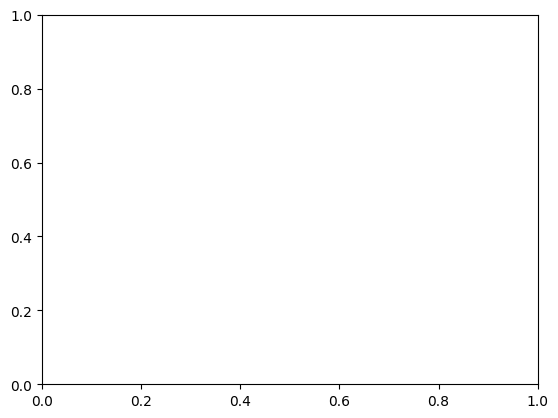

In [4]:
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

# Load the dataset
df = pd.read_csv("train.csv")

# Set the number of samples
samples = 20000

# Fix file path
base_path = r"C:\Python311"

# Filter the dataset based on the 'id' column
df = df.loc[df["id"].str.startswith('00', na=False), :]

# Get the number of unique classes and data size
num_classes = len(df["landmark_id"].unique())
num_data = len(df)
print("Size of training data:", df.shape)
print("Number of unique classes:", num_classes)

# Create a DataFrame to analyze the distribution of landmark IDs
data = pd.DataFrame(df['landmark_id'].value_counts())
data.reset_index(inplace=True)
data.columns = ['landmark_id', 'count']

# Display descriptive statistics and a histogram of the landmark IDs distribution
data['count'].describe()
plt.hist(data['count'], 100, range=(0, 944), label='test')
data['count'].between(0, 5).sum()
data['count'].between(5, 10).sum()
plt.hist(df["landmark_id"], bins=df["landmark_id"].unique())
plt.show()

# Training of Model

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
lencoder = LabelEncoder()

# Fit LabelEncoder to the landmark_id column
lencoder.fit(df["landmark_id"])

# Display the first few rows of the DataFrame
df.head()

# Define functions for encoding and decoding labels
def encode_label(lbl):
    return lencoder.transform(lbl)

def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

# Define a function to get an image and its label from a given index
def get_image_from_number(num):
    fname, label = df.loc[num, :]
    fname = fname + '.jpg'
    f1, f2, f3, fname = fname[0], fname[1], fname[2], fname
    path = os.path.join(f1, f2, f3, fname)
    im = cv2.imread(os.path.join(base_path, path))
    return im, label

# Display 4 sample images from random classes
print("4 Sample images from random classes")
fig = plt.figure(figsize=(16, 16))
for i in range(1, 5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = os.path.join(base_path, *ri)
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(os.path.join(folder, random_img)))  # Fix typo
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis("off")
plt.show()

from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential
tf.compat.v1.disable_eager_execution()

# Parameters for the model
learning_rate = 0.0001
decay_speed = 1e-6
momentum = 0.09
loss_function = "sparse_categorical_crossentropy"
source_model = VGG19(weights=None)
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)

# Create a Sequential model with VGG19 as base and additional layers
model = Sequential()
for layer in source_model.layers[:-1]:
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
model.add(Dense(num_classes, activation="softmax"))
model.summary()

# Fix the optimizer
optim1 = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(optimizer=optim1,
              loss=loss_function,
              metrics=["accuracy"])

# Define a function to reshape an image to a target size
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)  # Fix the function name

# Define a function to get a batch of images and labels
def get_batch(dataFrame, start, batch_size):
    image_array = []
    label_array = []

    end_img = start + batch_size
    if end_img > len(dataFrame):
        end_img = len(dataFrame)

    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)

    label_array = encode_label(label_array)
    return np.array(image_array), np.array(label_array)

# Set batch size, epochs, and other parameters
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 1

# Split the dataset into training and validation sets
train, val = np.split(df.sample(frac=1), [int(0.8 * len(df))])
print(len(train))
print(len(val))

# Train the model
for e in range(epochs):
    print("Epoch :" + str(e + 1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac=1)
    for it in range(int(np.ceil(len(train) / batch_size))):
        x_train, y_train = get_batch(train, it * batch_size, batch_size)
        model.train_on_batch(x_train, y_train)
    model.save("Model")

# Test the model on the validation set

batch_size = 16
errors = 0
good_preds = []
bad_pred = []

for it in range(int(np.ceil(len(val) / batch_size))):
    x_val, y_val = get_batch(val, it * batch_size, batch_size)
    result = model.predict(x_val)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        n = batch_size * it + idx  # Fix the index calculation
        if n < len(val):
            if cla[idx] != y_val[idx]:
                errors = errors + 1
                bad_pred.append([n, cla[idx], res[cla[idx]]])
            else:
                good_preds.append([n, cla[idx], res[cla[idx]]])

# Display 5 sample images from correctly predicted classes
print("5 Sample images from correctly predicted classes")
fig = plt.figure(figsize=(16, 16))
for i in range(1, min(6, len(good_preds) + 1)):  # Fix the loop to prevent index errors
    n = int(good_preds[i - 1][0])
    img, lbl = get_image_from_number(n)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    plt.title(f"True Label: {lbl}, Predicted Label: {good_preds[i - 1][1]}")
    plt.axis("off")
plt.show()

